# Data Collection and Preprocessing

In [ ]:
!git clone https://github.com/keshavrathinavel/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility

fatal: destination path 'Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility' already exists and is not an empty directory.


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

df_sp500 = pd.read_csv('/content/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility/S&p500.csv')
df_gpri = pd.read_csv('/content/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility/gpr_index.csv')
df_ftse = pd.read_csv('/content/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility/ftse.csv')
df_iomex = pd.read_csv('/content/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility/imoex.csv')
df_nifty = pd.read_csv('/content/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility/NIFTY.csv')
df_gdaxi = pd.read_csv('/content/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility/GDAXI.csv')
df_sse = pd.read_csv('/content/Geopolitical-Risk-Analysis-and-Its-Impact-on-Market-Volatility/SSE.csv')

# Taking only required columns
df_ftse = df_ftse[['Date', 'Close']]
df_imoex = df_ftse[['Date', 'Close']]
df_nifty = df_ftse[['Date', 'Close']]
df_gdaxi = df_gdaxi[['Date', 'Close']]
df_sse = df_sse[['Date', 'Close']]

# Convert the 'Date' columns to datetime format
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_gpri['Date'] = pd.to_datetime(df_gpri['Date'])
df_ftse['Date'] = pd.to_datetime(df_ftse['Date'])
df_imoex['Date'] = pd.to_datetime(df_imoex['Date'])
df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])
df_gdaxi['Date'] = pd.to_datetime(df_gdaxi['Date'])
df_sse['Date'] = pd.to_datetime(df_sse['Date'])

# Editing the columns of Financial Markets
df_ftse = df_ftse.rename(columns = {'Close' : 'FTSE'})
df_imoex = df_imoex.rename(columns = {'Close' : 'IMOEX'})
df_nifty = df_nifty.rename(columns = {'Close' : 'NIFTY'})
df_gdaxi = df_gdaxi.rename(columns = {'Close' : 'GDAXI'})
df_sse = df_sse.rename(columns = {'Close' : 'SSE'})

# Merge the indexes of the Financial Markets
indices = [df_ftse, df_imoex, df_nifty, df_sp500, df_gdaxi, df_sse]
data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='inner'), indices).fillna('void')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%y')

# Extract year and month for merging GPRI with the financial markets data
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
df_gpri['Date'] = pd.to_datetime(df_gpri['Date'])
df_gpri['Year'] = df_gpri['Date'].dt.year
df_gpri['Month'] = df_gpri['Date'].dt.month

# Merge on Year and Month
data = data.merge(df_gpri[['Year', 'Month', 'GPRI']], on=['Year', 'Month'], how='left')

# Drop unnecessary columns and change datatypes
data = data[['Date', 'S&P500', 'FTSE', 'GDAXI', 'NIFTY', 'IMOEX', 'SSE', 'GPRI']]
data['S&P500'] = data['FTSE'].str.replace(',', '').astype(float)
data['FTSE'] = data['FTSE'].str.replace(',', '').astype(float)

data = data.dropna(subset=['GPRI'])

# Sorting by Date
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
# data.sort_values('Date')

display(data)

,Date,S&P500,FTSE,GDAXI,NIFTY,IMOEX,SSE,GPRI
142,2023-01-31,7771.70,7771.70,15128.26953,"7,771.70","7,771.70",3255.669922,105.73
143,2023-01-31,7771.70,7771.70,15128.26953,"7,771.70","7,771.70",3255.669922,127.32
144,2023-01-31,7771.70,7771.70,15128.26953,"7,771.70","7,771.70",3255.669922,109.86
145,2023-01-31,7771.70,7771.70,15128.26953,"7,771.70","7,771.70",3255.669922,110.06
146,2023-01-31,7771.70,7771.70,15128.26953,"7,771.70","7,771.70",3255.669922,109.35
...,...,...,...,...,...,...,...,...
3708,2014-01-07,6755.45,6755.45,9902.410156,"6,755.45","6,755.45",2047.317017,136.45
3709,2014-01-07,6755.45,6755.45,9902.410156,"6,755.45","6,755.45",2047.317017,131.56
3710,2014-01-07,6755.45,6755.45,9902.410156,"6,755.45","6,755.45",2047.317017,83.66
3711,2014-01-07,6755.45,6755.45,9902.410156,"6,755.45","6,755.45",2047.317017,84.38


# Feature Engineering

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

numeric_cols = ['S&P500', 'FTSE', 'GDAXI', 'NIFTY', 'IMOEX', 'SSE', 'GPRI']
for col in numeric_cols:
    data[col] = data[col].astype(str).str.replace(',', '').astype(float)

# Define the date ranges for COVID period and Russia-Ukraine war period
covid_start = pd.to_datetime('2020-11-01', format='%Y-%m-%d')
covid_end = pd.to_datetime('2023-05-01', format='%Y-%m-%d')
russ_war_start = pd.to_datetime('2022-01-24', format='%Y-%m-%d')
russ_war_end = pd.to_datetime('2023-07-01', format='%Y-%m-%d')

# Define date ranges for a period of no major unrest
no_unrest_period_start = pd.to_datetime('2014-01-01', format='%Y-%m-%d')
no_unrest_period_end = pd.to_datetime('2017-11-11', format='%Y-%m-%d')

# Create the event dataframes
covid_period = data[(data['Date'] >= covid_start) & (data['Date'] <= covid_end)]
russ_war_period = data[(data['Date'] >= russ_war_start) & (data['Date'] <= russ_war_end)]
no_unrest_period = data[(data['Date'] >= no_unrest_period_start) & (data['Date'] <= no_unrest_period_end)]


feature_columns = ['S&P500', 'FTSE', 'GDAXI', 'NIFTY', 'IMOEX', 'SSE', 'GPRI']

covid_period = covid_period[feature_columns]
russ_war_period = russ_war_period[feature_columns]
no_unrest_period = no_unrest_period[feature_columns]

# Normalizing the Data

In [ ]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the numeric columns of these periods
covid_period_array = scaler.fit_transform(covid_period[numeric_cols])
russ_war_period_array = scaler.fit_transform(russ_war_period[numeric_cols])
no_unrest_period_array = scaler.fit_transform(no_unrest_period[numeric_cols])

In [ ]:
display(covid_period)
print(covid_period_array)

,S&P500,FTSE,GDAXI,NIFTY,IMOEX,SSE,GPRI
142,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,105.73
143,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,127.32
144,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,109.86
145,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,110.06
146,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,109.35
...,...,...,...,...,...,...,...
3322,7505.15,7505.15,14446.48047,7505.15,7505.15,3632.330078,135.08
3323,7505.15,7505.15,14446.48047,7505.15,7505.15,3632.330078,134.03
3324,7505.15,7505.15,14446.48047,7505.15,7505.15,3632.330078,145.90
3325,7505.15,7505.15,14446.48047,7505.15,7505.15,3632.330078,118.78


[[0.94504596 0.94504596 0.71934019 ... 0.94504596 0.26978383 0.17033403]
 [0.94504596 0.94504596 0.71934019 ... 0.94504596 0.26978383 0.2518211 ]
 [0.94504596 0.94504596 0.71934019 ... 0.94504596 0.26978383 0.18592187]
 ...
 [0.76039956 0.76039956 0.5075097  ... 0.76039956 1.         0.32194754]
 [0.76039956 0.76039956 0.5075097  ... 0.76039956 1.         0.2195886 ]
 [0.76039956 0.76039956 0.5075097  ... 0.76039956 1.         0.20139649]]


In [ ]:
display(russ_war_period)
print(russ_war_period_array)

,S&P500,FTSE,GDAXI,NIFTY,IMOEX,SSE,GPRI
142,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,105.73
143,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,127.32
144,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,109.86
145,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,110.06
146,7771.70,7771.70,15128.26953,7771.70,7771.70,3255.669922,109.35
...,...,...,...,...,...,...,...
3190,7297.15,7297.15,15011.12988,7297.15,7297.15,3524.110107,135.08
3191,7297.15,7297.15,15011.12988,7297.15,7297.15,3524.110107,134.03
3192,7297.15,7297.15,15011.12988,7297.15,7297.15,3524.110107,145.90
3193,7297.15,7297.15,15011.12988,7297.15,7297.15,3524.110107,118.78


[[0.85677403 0.85677403 0.22276784 ... 0.85677403 0.34141285 0.05106842]
 [0.85677403 0.85677403 0.22276784 ... 0.85677403 0.34141285 0.14426937]
 [0.85677403 0.85677403 0.22276784 ... 0.85677403 0.34141285 0.06889704]
 ...
 [0.         0.         0.09725656 ... 0.         1.         0.22447658]
 [0.         0.         0.09725656 ... 0.         1.         0.10740341]
 [0.         0.         0.09725656 ... 0.         1.         0.08659616]]


In [ ]:
display(no_unrest_period)
print(no_unrest_period_array)

,S&P500,FTSE,GDAXI,NIFTY,IMOEX,SSE,GPRI
427,6749.40,6749.40,10694.320310,6749.40,6749.40,3210.363037,111.99
428,6749.40,6749.40,10694.320310,6749.40,6749.40,3210.363037,111.92
429,6749.40,6749.40,10694.320310,6749.40,6749.40,3210.363037,104.24
430,6749.40,6749.40,10694.320310,6749.40,6749.40,3210.363037,102.19
431,6749.40,6749.40,10694.320310,6749.40,6749.40,3210.363037,76.26
...,...,...,...,...,...,...,...
3708,6755.45,6755.45,9902.410156,6755.45,6755.45,2047.317017,136.45
3709,6755.45,6755.45,9902.410156,6755.45,6755.45,2047.317017,131.56
3710,6755.45,6755.45,9902.410156,6755.45,6755.45,2047.317017,83.66
3711,6755.45,6755.45,9902.410156,6755.45,6755.45,2047.317017,84.38


[[0.64643709 0.64643709 0.34878739 ... 0.64643709 0.87460839 0.52606461]
 [0.64643709 0.64643709 0.34878739 ... 0.64643709 0.87460839 0.52520803]
 [0.64643709 0.64643709 0.34878739 ... 0.64643709 0.87460839 0.43122859]
 ...
 [0.65007241 0.65007241 0.16269334 ... 0.65007241 0.03074084 0.17939305]
 [0.65007241 0.65007241 0.16269334 ... 0.65007241 0.03074084 0.18820362]
 [0.65007241 0.65007241 0.16269334 ... 0.65007241 0.03074084 0.21451297]]


# Creating Data Sequences

- To maintain temporal order of the data.

In [ ]:
def create_sequences_with_labels(data, n_steps_in, n_steps_out, label):
    X, y, labels = [], [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
        labels.append(label)  # Add the label
    return np.array(X), np.array(y), np.array(labels)


In [ ]:
# 30 days to predict the next day
n_steps_in = 30
n_steps_out = 1


# Create COVID and Russia-Ukraine war data sequences
X_covid, y_covid, labels_covid = create_sequences_with_labels(covid_period_array, n_steps_in, n_steps_out, label=2)
X_war, y_war, labels_war = create_sequences_with_labels(russ_war_period_array, n_steps_in, n_steps_out, label=1)
X_rest, y_rest, labels_rest = create_sequences_with_labels(no_unrest_period_array, n_steps_in, n_steps_out, label=0)


# Concatenate the obtained sequences to make a merged dataset
X_combined = np.concatenate((X_covid, X_war), axis=0)
y_combined = np.concatenate((y_covid, y_war), axis=0)
labels_combined = np.concatenate((labels_covid, labels_war), axis=0)


Class Counts: {1: 121, 2: 457}


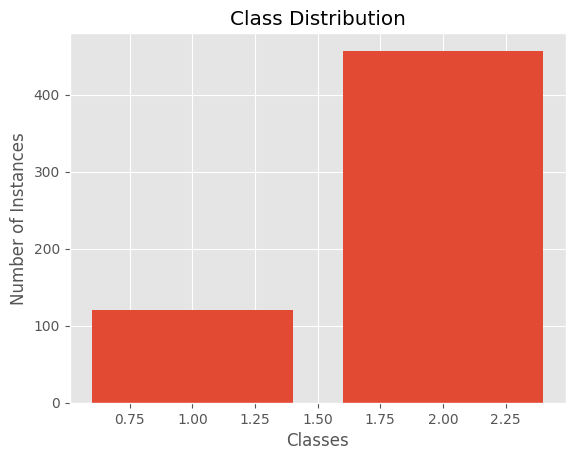

In [ ]:
# Check for class imbalance
unique, counts = np.unique(labels_combined, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class Counts:", class_counts)

plt.style.use('ggplot')
# Visual representation
labels, counts = zip(*class_counts.items())
plt.bar(labels, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()


In [ ]:
train_size = int(len(X_combined) * 0.8)

# Split the feature dataset
X_train, X_test = X_combined[:train_size], X_combined[train_size:]
# Split the target dataset
y_train, y_test = y_combined[:train_size], y_combined[train_size:]
# Split the labels
labels_train, labels_test = labels_combined[:train_size], labels_combined[train_size:]


# Model Training

# Without Attention Layer

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf


n_steps_in = 30
n_features = 6

input_layer = Input(shape=(n_steps_in, n_features))
# return_sequences = False because we are using 30 days to predict 1 (many to one model)
lstm_layer = Bidirectional(LSTM(50, return_sequences=False))(input_layer)  # Set return_sequences to False
dense_layer = Dense(50, activation='relu')(lstm_layer)
dropout_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(1)(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 30, 6)]           0         
                                                                 
 bidirectional_19 (Bidirect  (None, 100)               22800     
 ional)                                                          
                                                                 
 dense_34 (Dense)            (None, 50)                5050      
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 27901 (108.99 KB)
Trainable params: 27901 (108.99 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit the model on the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model's performance
performance = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Reshaping the arrays
y_pred = y_pred.reshape(-1, y_pred.shape[-1])  # Now y_pred is 2D: samples x features
y_test = y_test.reshape(-1, y_test.shape[-1])  # Now y_test is also 2D

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')


Epoch 1/50
15/15 [==============================] - 7s 161ms/step - loss: 0.0641 - val_loss: 0.0465
Epoch 2/50
15/15 [==============================] - 1s 80ms/step - loss: 0.0338 - val_loss: 0.0537
Epoch 3/50
15/15 [==============================] - 1s 66ms/step - loss: 0.0294 - val_loss: 0.0493
Epoch 4/50
15/15 [==============================] - 1s 68ms/step - loss: 0.0260 - val_loss: 0.0472
Epoch 5/50
15/15 [==============================] - 1s 98ms/step - loss: 0.0263 - val_loss: 0.0509
Epoch 6/50
15/15 [==============================] - 1s 54ms/step - loss: 0.0246 - val_loss: 0.0500
Epoch 7/50
15/15 [==============================] - 1s 57ms/step - loss: 0.0249 - val_loss: 0.0454
Epoch 8/50
15/15 [==============================] - 1s 56ms/step - loss: 0.0259 - val_loss: 0.0525
Epoch 9/50
15/15 [==============================] - 1s 60ms/step - loss: 0.0253 - val_loss: 0.0471
Epoch 10/50
15/15 [==============================] - 1s 67ms/step - loss: 0.0251 - val_loss: 0.0462
Epoch 11

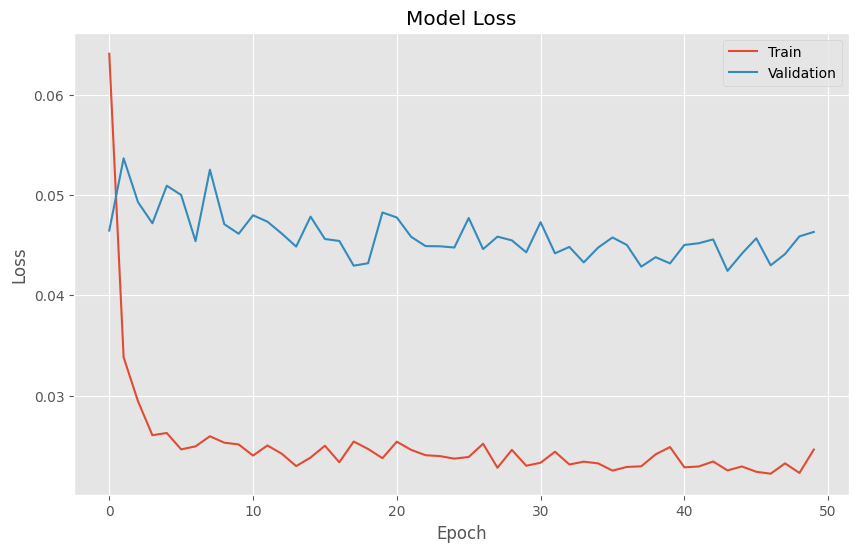

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Making predictions using this model
predictions = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

4/4 [==============================] - 0s 7ms/step
Mean Absolute Error: 0.11166328413555697
Root Mean Squared Error: 0.2152538042137947


In [ ]:
!pip install matplotx

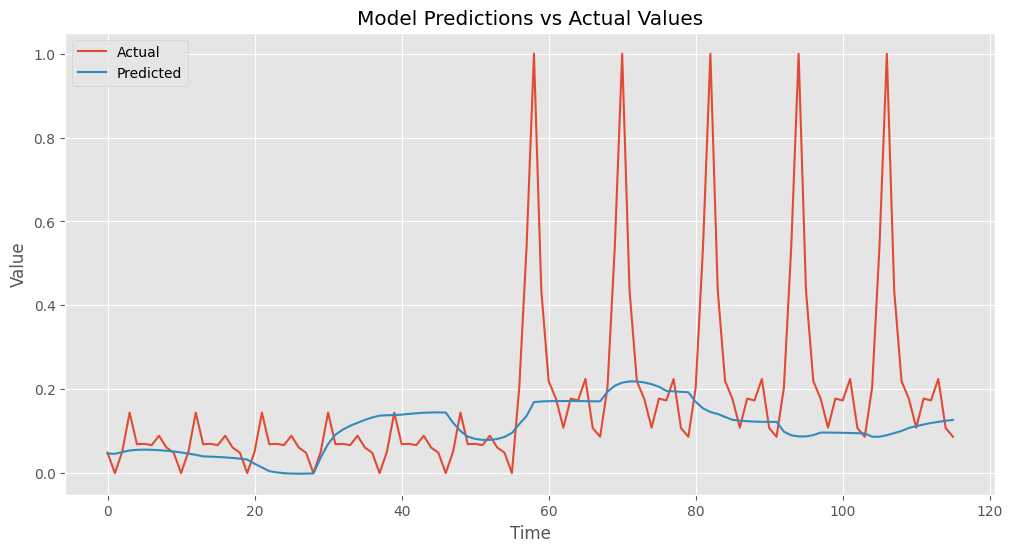

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


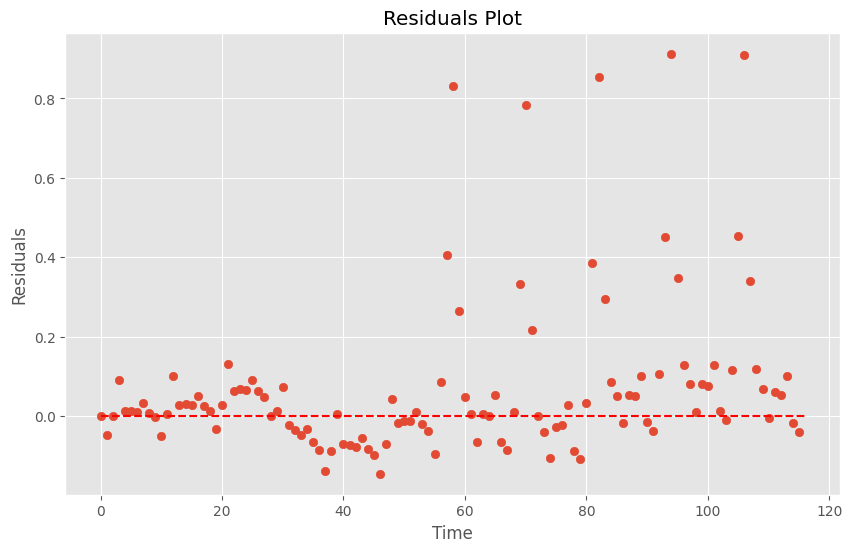

In [ ]:
plt.style.use('ggplot')
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals)
plt.hlines(y=0, xmin=0, xmax=len(residuals), colors='r', linestyles='--')
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()


In [ ]:
from scipy import stats

def calculate_prediction_intervals(predictions, y_train, model, X_train, confidence=0.95):
    """
    Adjusted for the presence of outliers in the residual plot (non-normal plot seen)

    :param confidence: float, the confidence level for the prediction interval
    """
    train_predictions = model.predict(X_train)
    residuals = y_train - train_predictions
    # Instead of standard deviation, use median absolute deviation for a robust measure
    median_residual = np.median(residuals) # Does not assume normality in this case
    mad = np.median(np.abs(residuals - median_residual))
    scale_factor = stats.norm.ppf((1 + confidence) / 2)
    interval_half_width = scale_factor * mad
    lower_bound = predictions - interval_half_width
    upper_bound = predictions + interval_half_width
    return lower_bound, upper_bound


lower_bound, upper_bound = calculate_prediction_intervals(predictions, y_train, model, X_train)


15/15 [==============================] - 0s 11ms/step


15/15 [==============================] - 0s 13ms/step


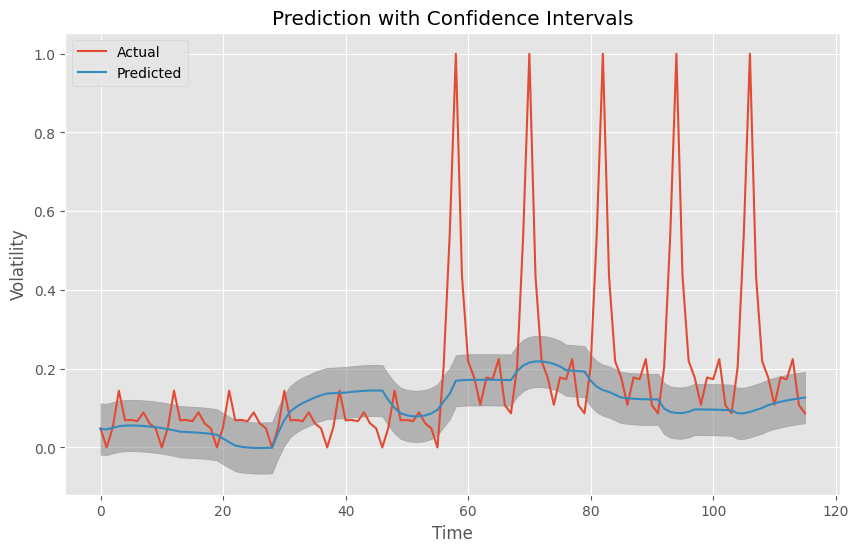

In [ ]:
lower_bound, upper_bound = calculate_prediction_intervals(predictions, y_train, model, X_train)

# Flatten the arrays to ensure they are one-dimensional
lower_bound = lower_bound.flatten()
upper_bound = upper_bound.flatten()

# Plotting the actual values, predictions, and prediction intervals
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
# Make sure that 'x' and 'y' dimensions match
plt.fill_between(range(len(predictions)), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.title('Prediction with Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


# With Attention Layer

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Flatten, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Attention class
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)


    def build(self, input_shape):
        # Assuming the input_shape is of the form (batch_size, timesteps, features)
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return output


In [ ]:
# Adjust the LSTM and model structure
input_layer = Input(shape=(n_steps_in, n_features))
lstm_layer = Bidirectional(LSTM(50, return_sequences=True))(input_layer)
attention_layer = Attention()(lstm_layer)
flattened = Flatten()(attention_layer)  # Flatten the output
dense_layer = Dense(50, activation='relu')(flattened)
dropout_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(1)(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 30, 6)]           0         
                                                                 
 bidirectional_20 (Bidirect  (None, 30, 100)           22800     
 ional)                                                          
                                                                 
 attention_9 (Attention)     (None, 30, 100)           130       
                                                                 
 flatten_5 (Flatten)         (None, 3000)              0         
                                                                 
 dense_36 (Dense)            (None, 50)                150050    
                                                                 
 dropout_18 (Dropout)        (None, 50)                0         
                                                          

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit the model on the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model's performance
performance = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Reshaping the arrays
y_pred = y_pred.reshape(-1, y_pred.shape[-1])  # Now y_pred is 2D: samples x features
y_test = y_test.reshape(-1, y_test.shape[-1])  # Now y_test is also 2D

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')


Epoch 1/50
15/15 [==============================] - 6s 106ms/step - loss: 0.0439 - val_loss: 0.0553
Epoch 2/50
15/15 [==============================] - 1s 51ms/step - loss: 0.0327 - val_loss: 0.0665
Epoch 3/50
15/15 [==============================] - 1s 69ms/step - loss: 0.0303 - val_loss: 0.0561
Epoch 4/50
15/15 [==============================] - 1s 84ms/step - loss: 0.0302 - val_loss: 0.0658
Epoch 5/50
15/15 [==============================] - 1s 64ms/step - loss: 0.0277 - val_loss: 0.0566
Epoch 6/50
15/15 [==============================] - 1s 63ms/step - loss: 0.0258 - val_loss: 0.0529
Epoch 7/50
15/15 [==============================] - 1s 65ms/step - loss: 0.0254 - val_loss: 0.0519
Epoch 8/50
15/15 [==============================] - 1s 57ms/step - loss: 0.0252 - val_loss: 0.0534
Epoch 9/50
15/15 [==============================] - 1s 54ms/step - loss: 0.0248 - val_loss: 0.0525
Epoch 10/50
15/15 [==============================] - 1s 59ms/step - loss: 0.0254 - val_loss: 0.0506
Epoch 11

In [ ]:
# Making predictions using this model
predictions = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

4/4 [==============================] - 0s 9ms/step
Mean Absolute Error: 0.13869716602541524
Root Mean Squared Error: 0.2164181108713176


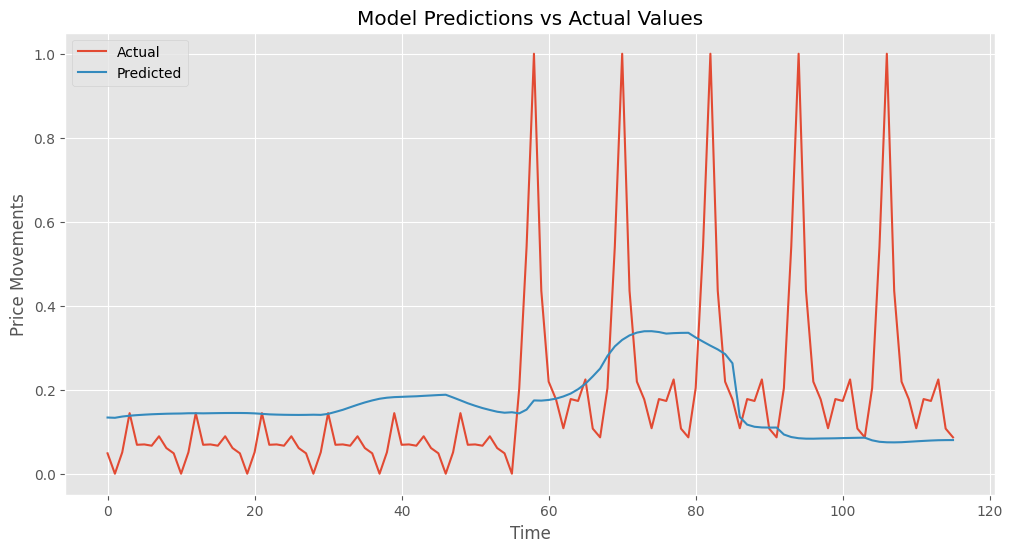

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Price Movements')
plt.legend()
plt.show()


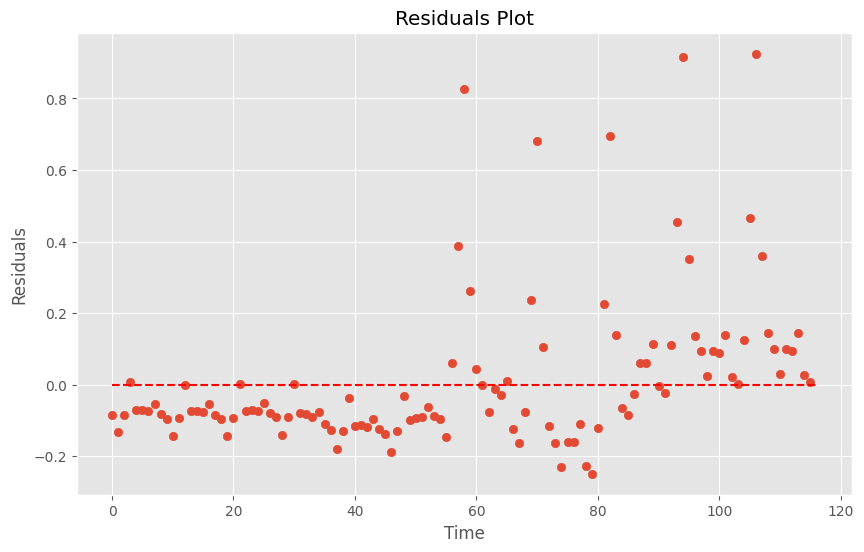

In [ ]:

plt.style.use('ggplot')
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals)
plt.hlines(y=0, xmin=0, xmax=len(residuals), colors='r', linestyles='--')
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Custom Attention

In [ ]:
n_features = 6 # Number of features excluding GPRI

# # Adjust the create_sequences function to use the correct number of features
# def create_sequences(data, n_steps_in, n_steps_out):
#     X, y = [], []
#     for i in range(len(data) - n_steps_in - n_steps_out + 1):
#         # Use all features except GPRI for X
#         seq_x = data[i:(i + n_steps_in), :n_features]
#         # Use GPRI as target y
#         seq_y = data[(i + n_steps_in):(i + n_steps_in + n_steps_out), -1]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)


# n_steps_in = 30
# n_steps_out = 1


# X_covid, y_covid = create_sequences(covid_period_array, n_steps_in, n_steps_out)
# X_war, y_war = create_sequences(russ_war_period_array, n_steps_in, n_steps_out)
# X_rest, y_rest = create_sequences(no_unrest_period_array, n_steps_in, n_steps_out)


# X_combined = np.concatenate((X_covid, X_war, X_rest), axis=0)
# y_combined = np.concatenate((y_covid, y_war, y_rest), axis=0)


# train_size = int(len(X_combined) * 0.8)
# X_train, X_test = X_combined[:train_size], X_combined[train_size:]
# y_train, y_test = y_combined[:train_size], y_combined[train_size:]


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Flatten, Layer
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K


# Define the Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)



def weighted_mse(y_true, y_pred):
    weights = K.abs(y_true - y_pred)  # Larger errors will have larger weights
    return K.mean(weights * K.square(y_true - y_pred))


# Model architecture with increased complexity
input_layer = Input(shape=(n_steps_in, n_features))
lstm_layer1 = Bidirectional(LSTM(100, return_sequences=True))(input_layer)  # Increase the number of units
lstm_layer2 = Bidirectional(LSTM(50, return_sequences=False))(lstm_layer1)  # Add an additional layer
dense_layer = Dense(50, activation='relu')(lstm_layer2)
dropout_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(1)(dropout_layer)  # Output layer with a single neuron for regression

model = Model(inputs=input_layer, outputs=output_layer)


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Function to update the learning rate over epochs
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Define the initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss=weighted_mse)
# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Model summary
model.summary()


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 30, 6)]           0         
                                                                 
 bidirectional_31 (Bidirect  (None, 30, 200)           85600     
 ional)                                                          
                                                                 
 bidirectional_32 (Bidirect  (None, 100)               100400    
 ional)                                                          
                                                                 
 dense_48 (Dense)            (None, 50)                5050      
                                                                 
 dropout_24 (Dropout)        (None, 50)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 51 

In [ ]:
# Train the model with the new complexity and learning rate scheduler
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler],  # Add the learning rate scheduler callback
    verbose=1
)


Epoch 1/50
15/15 [==============================] - 12s 188ms/step - loss: 0.0218 - val_loss: 0.0310 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 1s 89ms/step - loss: 0.0157 - val_loss: 0.0289 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 2s 119ms/step - loss: 0.0132 - val_loss: 0.0253 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 1s 92ms/step - loss: 0.0137 - val_loss: 0.0238 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 1s 68ms/step - loss: 0.0117 - val_loss: 0.0271 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 1s 67ms/step - loss: 0.0124 - val_loss: 0.0289 - lr: 0.0010
Epoch 7/50
15/15 [==============================] - 1s 69ms/step - loss: 0.0126 - val_loss: 0.0265 - lr: 0.0010
Epoch 8/50
15/15 [==============================] - 1s 68ms/step - loss: 0.0106 - val_loss: 0.0257 - lr: 0.0010
Epoch 9/50
15/15 [==============================] - 1s 69ms/step - loss: 0.0129 - val_loss: 0.0243 - 

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")


4/4 [==============================] - 2s 25ms/step
Test MSE: 0.044492566224163144


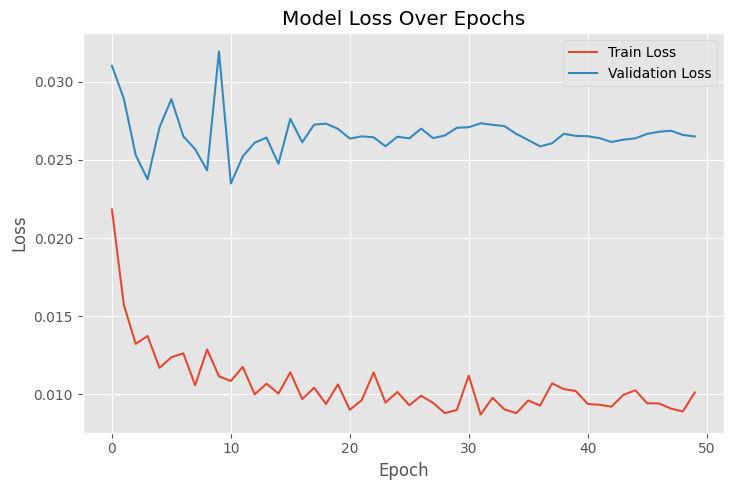

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


def plot_model_performance(history):
    plt.figure(figsize=(14, 5))

    # Plot loss over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # history includes 'mse'
    if 'mse' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mse'], label='Train MSE')
        plt.plot(history.history['val_mse'], label='Validation MSE')
        plt.title('Model MSE Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, label='Actual GPRI', color='red', linewidth=1)
    plt.plot(y_pred, label='Predicted GPRI', color='blue', linewidth=1)
    plt.title('GPRI: Predicted vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Normalized GPRI Value')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Test MSE: {mse}")

plot_model_performance(history)


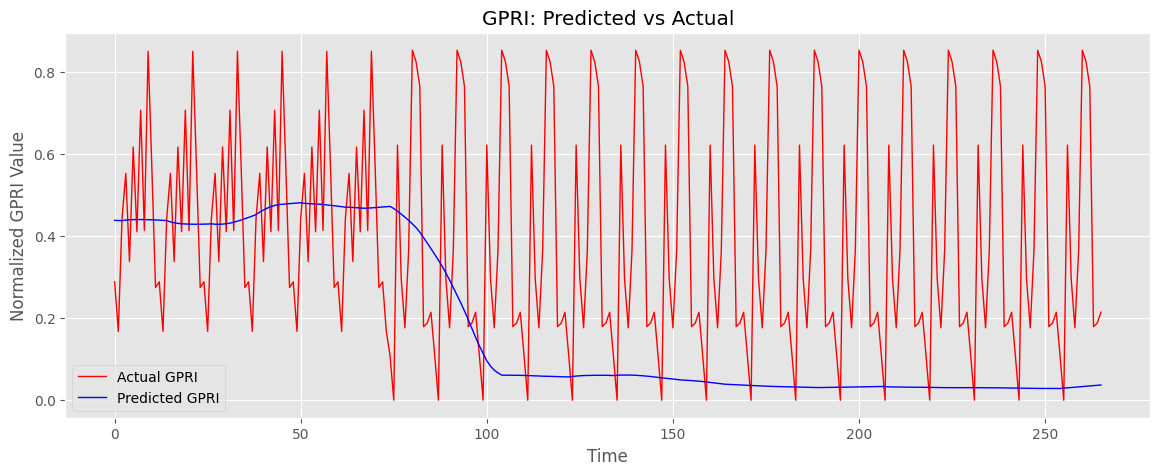

Test MSE: 0.14521912079469998


In [ ]:
plot_predictions(y_test, y_pred)